## Vegan Restaurant Analysis in Kiel: Finding the Optimal Cluster with Minimal Competition 🌱🗺️

# Task 1 - Story

<div class="alert alert-block alert-info">
In this Notebook, I will investigate clusters of vegan restaurants around Kiel, and help new companies find the optimal cluster with minimal competition.
</div>

# Task 2 - The Data

In [119]:
import pandas as pd
import matplotlib.pyplot as plt

In [120]:
# importing data from csv file
# the data was querryed from an OpenStreetMap API in the gettingData.ipynb
data = pd.read_csv("data/restaurants_kiel.csv")

data.set_index("id", inplace=True)

The OpenStreetMap API returns an table of different restaurants and 122 attributes that are related to the restaurants.
To do this we need lattitute and longitude wich is represented in this dataset.

In [121]:
data.head(3)

,Unnamed: 0,type,lat,lon,addr:city,addr:country,addr:housenumber,addr:postcode,addr:street,amenity,...,changing_table:fee,drink:soy_milk,payment:electronic_purses,drink:coffee,bar,internet_access:ssid,currency:BCH,image,operator:type,note:de
id,,,,,,,,,,,,,,,,,,,,,
125623466,0,node,54.338116,10.128011,Kiel,DE,82,24118.0,Hansastraße,restaurant,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125625723,1,node,54.337606,10.124073,Kiel,NaN,389,24118.0,Westring,cafe,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125626070,2,node,54.339351,10.123098,Kiel,NaN,2,24118.0,Rudolf-Höber-Straße,cafe,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Task 3 - IDA

## Geografical analysis

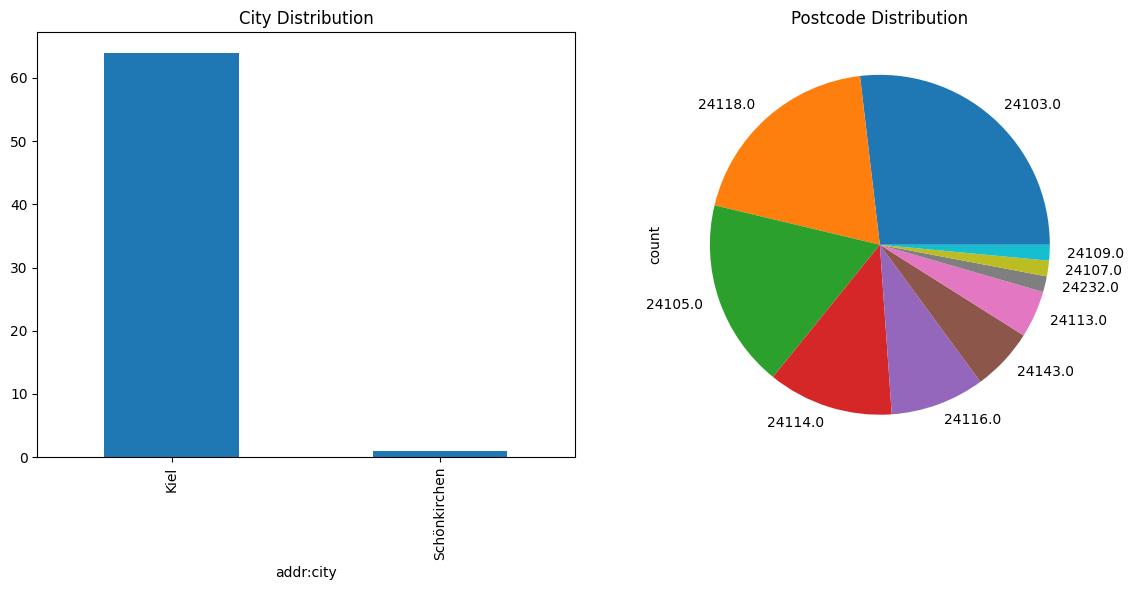

In [135]:
# Print the add:city distribution in a bar chart
plt.figure(figsize=(12, 6))  # Set the figure size as needed
plt.subplot(1, 2, 1)
plt.title('City Distribution')
data['addr:city'].value_counts().plot(kind='bar', ax=plt.gca())

# Print the add:postcode distribution in a pie chart
plt.subplot(1, 2, 2)
plt.title('Postcode Distribution')
data['addr:postcode'].value_counts().plot(kind='pie', ax=plt.gca())

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

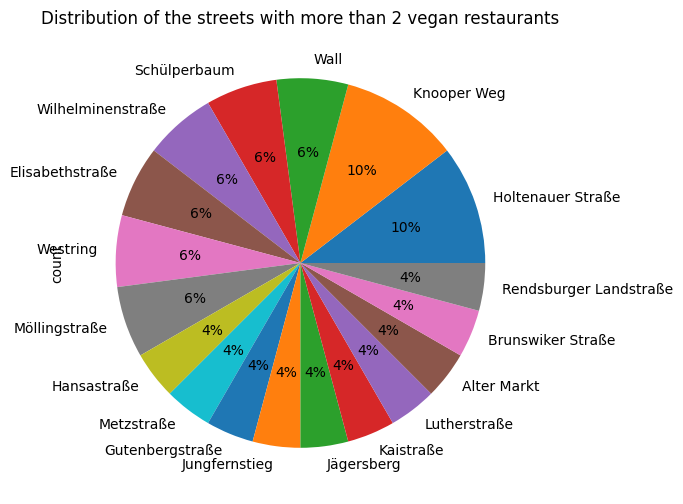

In [146]:
# only return the values that are represented 2 or more times

# Only return the values that are represented 2 or more times
data_filtered = data["addr:street"].value_counts()[data["addr:street"].value_counts() >= 2]

# Plot the pie chart with labels
plt.figure(figsize=(12, 6))  # Set the figure size as needed
data_filtered.plot.pie(autopct="%1.0f%%")
plt.title("Distribution of the streets with more than 2 vegan restaurants")
plt.show()

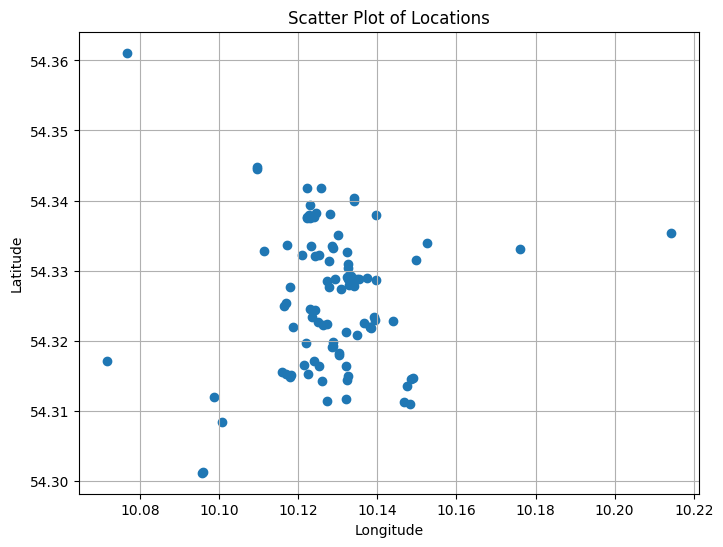

In [141]:
# Create a simple scatter plot
# TODO schön machen mit richtiger Karte :), vlt auch so daneben
plt.figure(figsize=(8, 6))
plt.scatter(data['lon'], data['lat'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter Plot of Locations')
plt.grid(True)
plt.show()

In [94]:
# display statistical values about lat an lon
data[["lat", "lon"]].describe()

,lat,lon
count,96.000000,96.000000
mean,54.325829,10.128190
std,0.010236,0.016734
min,54.301161,10.071640
25%,54.317800,10.122422
50%,54.326405,10.128221
75%,54.332849,10.134093
max,54.361095,10.214153


## restaurant analysis

<Axes: title={'center': 'Cuisine Distribution'}, xlabel='cuisine'>

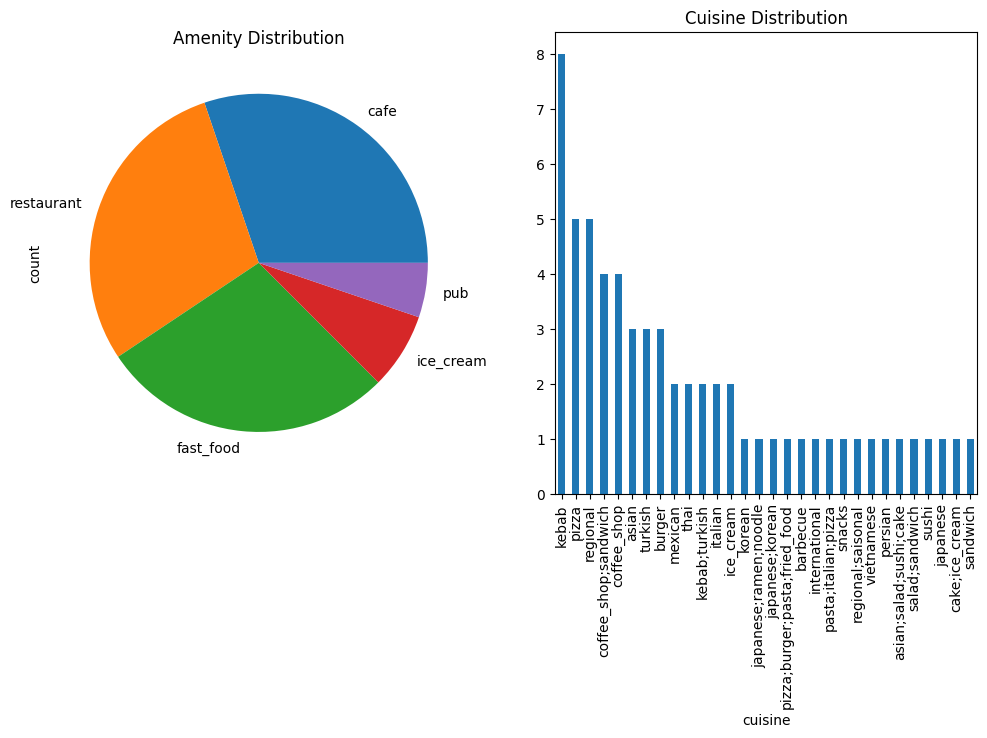

In [138]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Amenity Distribution")
data["amenity"].value_counts().plot(kind="pie", ax=plt.gca())

plt.subplot(1, 2, 2)
plt.title('Cuisine Distribution')
data["cuisine"].value_counts().plot(kind="bar", ax=plt.gca())

as we can see in the left graph above there are kinda equal ammount of fast_food, cafe and normal vegan restaurant distribution in kiel

<Axes: title={'center': 'Wheelchair accessibility in vegan restaurants'}, ylabel='count'>

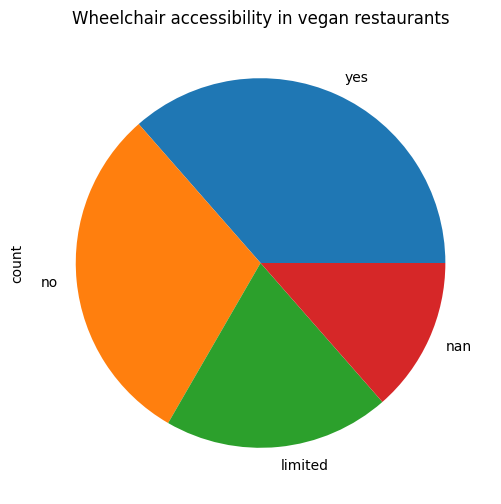

In [151]:
plt.figure(figsize=(12, 6))
plt.title('Wheelchair accessibility in vegan restaurants')
data["wheelchair"].value_counts(dropna=False).plot.pie()

this shows the distribution of wheelchare access, but the nan values have to be taken into consideration aswell

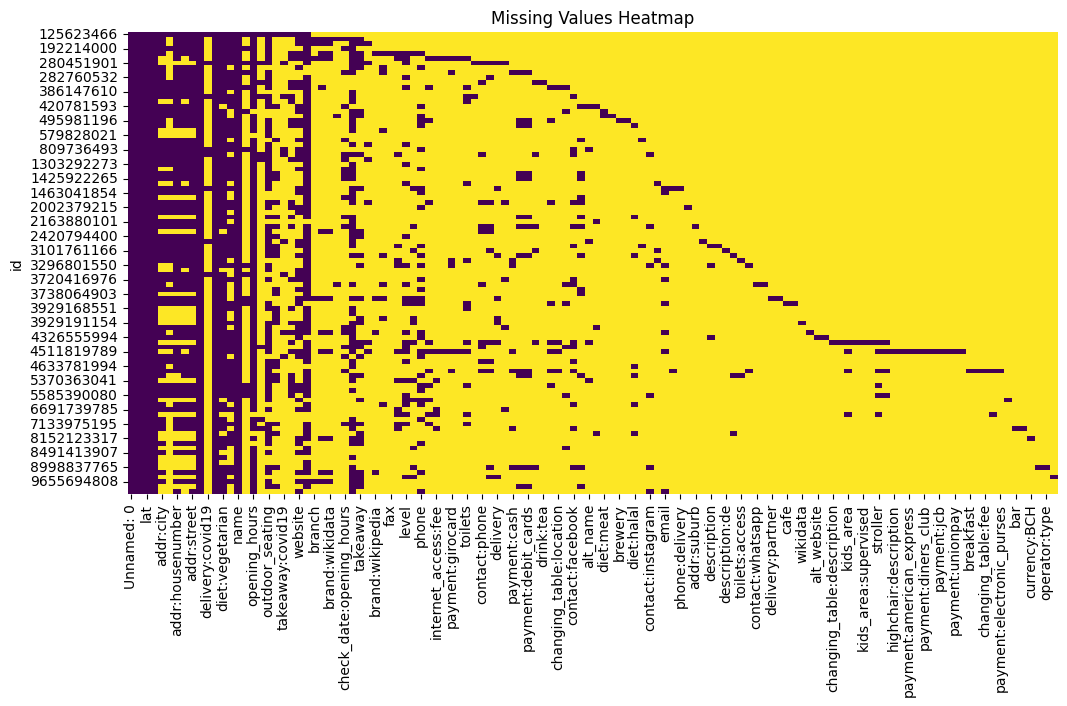

In [158]:
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.heatmap(data.isna(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

# inspired by https://stackoverflow.com/questions/47685905/matplotlib-heat-map-some-entries-missing-values

the heatmap above shows us what values are missing
on the y axis are different rows from the data
on the x axis are different attributes from the dataset

yellow entries represent a missing value of an attribute 
violette entries representing a present value of an attribute

on the left hand sinde we can see the attributes wich are commonly filled whil on the right hand sinde are mostly filled with nan values

In [93]:
# count na per attrobute of data

data.isna().sum().sort_values(ascending=True).head(10)

Unnamed: 0          0
type                0
lat                 0
name                0
amenity             0
diet:vegan          0
lon                 0
opening_hours       5
diet:vegetarian     8
wheelchair         13
dtype: int64

since open street map is a tool to display information on a UTM Map there are lat and lon values for every restaurant entry

looking at the lattitude and longitude we can see that there is a higher standard deriviation in lon so they are mor unequal on the y-axis on the map

# Task 4 - EDA and Preprocessing

In [96]:
# Since Unnamed: 0 is a index column, we will drop it
data.drop(columns=["Unnamed: 0"], inplace=True)

In [97]:
# since all attributes are from vegan restaurants and are nodes in OSM, we can drop the following columns
data.drop(columns=["type", "diet:vegan", "diet:vegetarian"], inplace=True)

In [98]:
# transforming wheelchair to categorical data
data["wheelchair"] = data["wheelchair"].astype("category")
data["amenity"] = data["amenity"].astype("category")

In [99]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96 entries, 125623466 to 10825168020
Columns: 118 entries, lat to note:de
dtypes: category(2), float64(5), object(111)
memory usage: 88.3+ KB


# Task 5 - Dimensionality Reduction

# Task 6 - Clustering

## Determine the right ammount of clusters

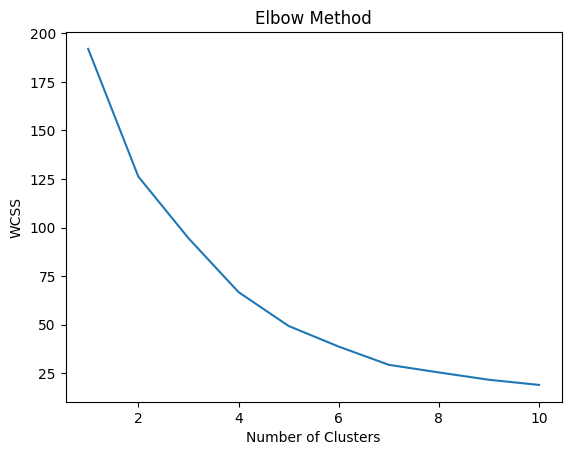

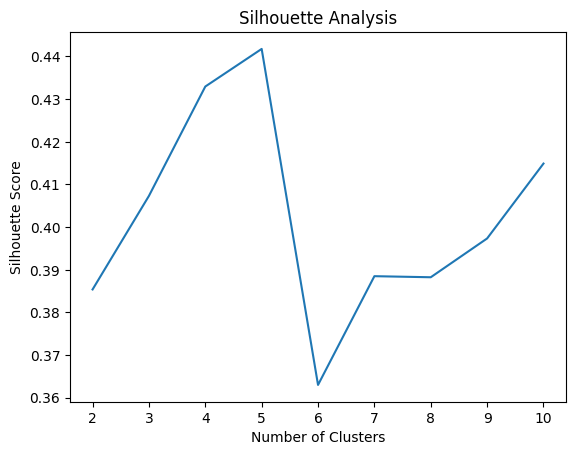

The silhouette score for the best cluster is: 0.44176858374157035


In [100]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Select the columns of interest
selected_columns = data[["lat", "lon"]]

# Standardize the data
scaler = StandardScaler()
selected_columns_scaled = scaler.fit_transform(selected_columns)

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
selected_columns_pca = pca.fit_transform(selected_columns_scaled)

# Perform elbow method to find the optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(selected_columns_pca)
    wcss.append(kmeans.inertia_)

# Plot the elbow method
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# Perform silhouette analysis
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(selected_columns_pca)
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(selected_columns_pca, labels))

# Plot silhouette scores
plt.plot(range(2, 11), silhouette_scores)
plt.title('Silhouette Analysis')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# returning the silhouette score for the best cluster
print("The silhouette score for the best cluster is: " + str(max(silhouette_scores)))

Based on our rule of Thumb a Silhouette score from 0 till 0.5 is not that good since the clusters do not seperate that good.
Anyway for demonstration purposes we are going to use them in this notebook.

/home/mbrucker/sem1/sem1_math_and_stats/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


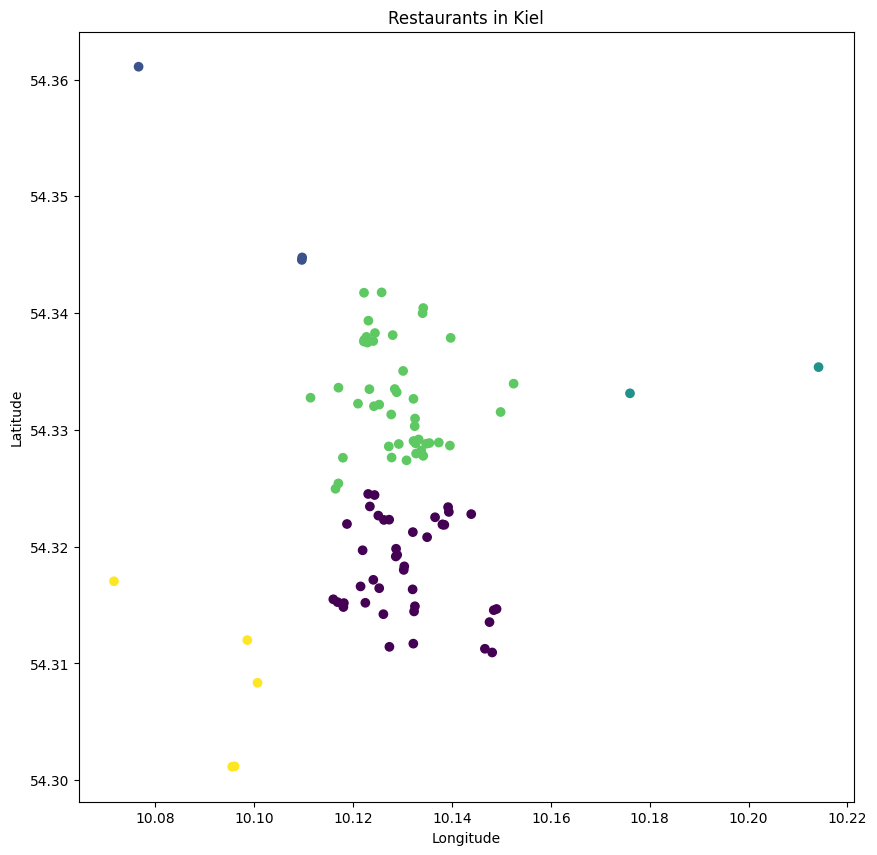

In [163]:
# Apply K-means clustering to the dataset
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select only the numeric columns (lat and lon)
restaurants_kiel_numeric = data[['lat', 'lon']].dropna()

# Standardize the numeric columns
scaler = StandardScaler()
restaurants_kiel_scaled = scaler.fit_transform(restaurants_kiel_numeric)

# Apply K-means clustering
kmeans = KMeans(n_clusters=5, random_state=0).fit(restaurants_kiel_scaled)

# Add the cluster labels to the dataframe
data['cluster'] = kmeans.labels_

# Plot the restaurants
plt.figure(figsize=(10, 10))
plt.scatter(data['lon'], data['lat'], c=data['cluster'], cmap='viridis')
plt.title('Restaurants in Kiel')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [166]:
import folium
# Create a map centered around Kiel
m = folium.Map(location=[54.3233, 10.1228], zoom_start=13)

# Define a color map for the clusters
cluster_colors = {0: 'blue', 1: 'green', 2: 'red', 3: 'purple', 4: 'orange'}

# Add markers for each restaurant with cluster color
for index, row in data.iterrows():
    folium.CircleMarker([row['lat'], row['lon']], radius=5, color=cluster_colors[row['cluster']], fill=True, fill_color=cluster_colors[row['cluster']]).add_to(m)

# Save the map to an HTML file
m.save('kiel_restaurants_clustered_5clusters.html')

# Display the map
m

# Task 7 - Cluster Interpretation

In [102]:
# print the density of the amenitys of the clusters in a chart

for cluster in range(n_clusters):
    cluster_data = data[data['cluster'] == cluster]
    print(f'Cluster {cluster + 1}: {cluster_data["amenity"].value_counts()}')

Cluster 1: amenity
fast_food     10
cafe           7
restaurant     4
ice_cream      3
pub            2
Name: count, dtype: int64
Cluster 2: amenity
restaurant    14
cafe          10
fast_food     10
pub            3
ice_cream      1
Name: count, dtype: int64
Cluster 3: amenity
fast_food     3
restaurant    1
ice_cream     1
cafe          0
pub           0
Name: count, dtype: int64
Cluster 4: amenity
fast_food     2
cafe          0
ice_cream     0
pub           0
restaurant    0
Name: count, dtype: int64
Cluster 5: amenity
cafe          12
restaurant     9
ice_cream      2
fast_food      1
pub            0
Name: count, dtype: int64
Cluster 6: amenity
fast_food     1
cafe          0
ice_cream     0
pub           0
restaurant    0
Name: count, dtype: int64


The siluette score of 0.44 at 6 clusters isnt the best 

# Task 8 - Conclusion and Future Work

On basis of the data i would reccomend the new enterprise to be open


Improvements that could be made:
Sure thing, the better the data basis the more analysis is possible to be done with the data. As presentet there are many attributes that are filled wit NAN values, with a broader participation in the open street map community further analysis would be possible to be done.

# SE GRAVE FOR FORGOTTEN COMANDS

# Cleaning the data

In [103]:
# Since alot of attributes are only available for a few restaurants, we will drop them

# we will drop attributes that are represented in less than 80% of the data
# the following how to calculate the percentage of na values in a column

print("For a attribute to be represented in 80 of the data, it can only have " + str(len(data) * 0.8) + " na values")

# drop colums with more than 20% na values
data.dropna(thresh=(len(data) * 0.8), axis=1, inplace=True)

For a attribute to be represented in 80 of the data, it can only have 76.80000000000001 na values


In [104]:
data.isna().sum().sort_values(ascending=True).head(25)

lat               0
lon               0
amenity           0
name              0
cluster           0
opening_hours     5
wheelchair       13
dtype: int64

In [105]:
# Analysing how many unique values each column has to get the value of the individual column

print("The ammount of unique values in each column is:")
data.nunique().sort_values(ascending=True).head(25)


The ammount of unique values in each column is:


wheelchair        3
amenity           5
cluster           6
opening_hours    87
name             90
lon              96
lat              96
dtype: int64

## Removing Outliners

Removing outliners based on lat and lon



In [106]:
import seaborn as sns

/tmp/ipykernel_26590/3392433084.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data["lat"])
/tmp/ipykernel_26590/3392433084.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data["lon"])


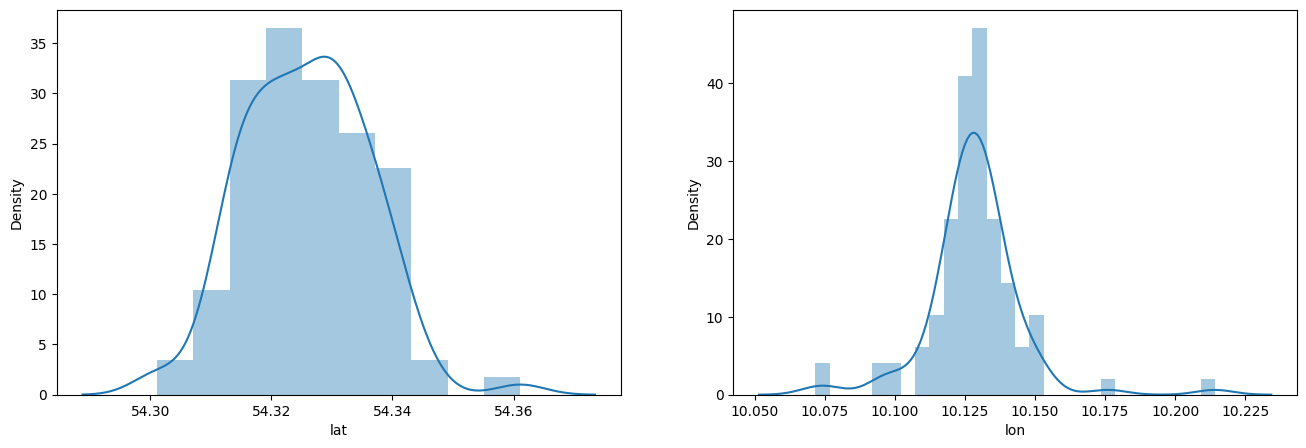

In [107]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(data["lat"])
plt.subplot(1,2,2)
sns.distplot(data["lon"])
plt.show()

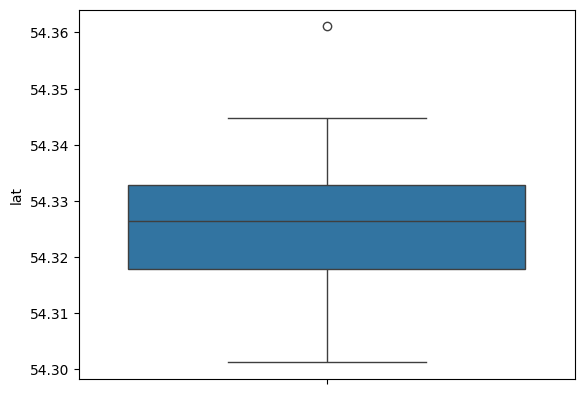

<Axes: ylabel='lon'>

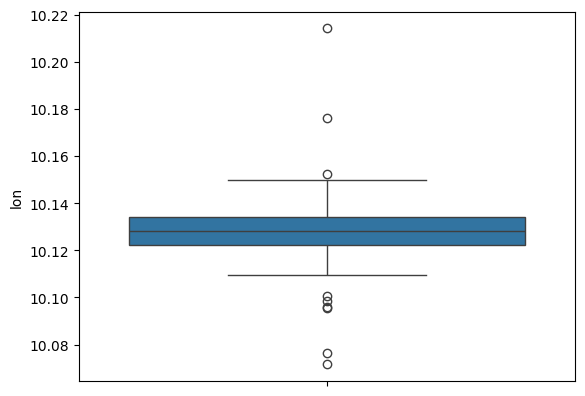

In [108]:
sns.boxplot(data['lat'])
plt.show()
sns.boxplot(data['lon'])

In [109]:
percentile25 = data['lat'].quantile(0.25)
percentile75 = data['lat'].quantile(0.75)

# Data visualization

<Axes: ylabel='count'>

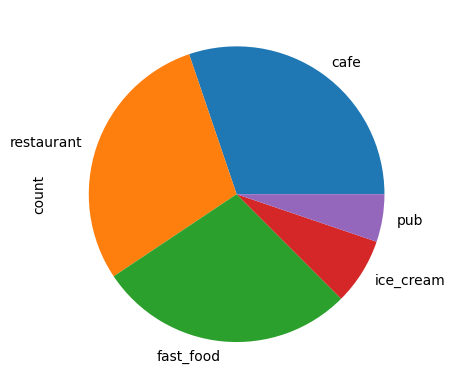

In [110]:
# the distribution of amenity as a pie chart

data["amenity"].value_counts().plot.pie()

In [111]:
# the distribution of cuisine as a pie chart

data_raw["cuisine"].value_counts().plot.pie()

NameError: name 'data_raw' is not defined

<Axes: ylabel='count'>

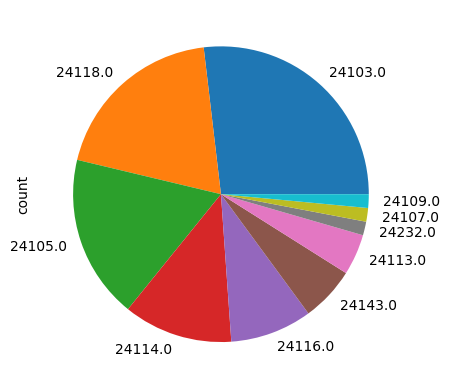

In [ ]:
# display more information about the dataset

data_raw["addr:postcode"].value_counts().plot.pie()

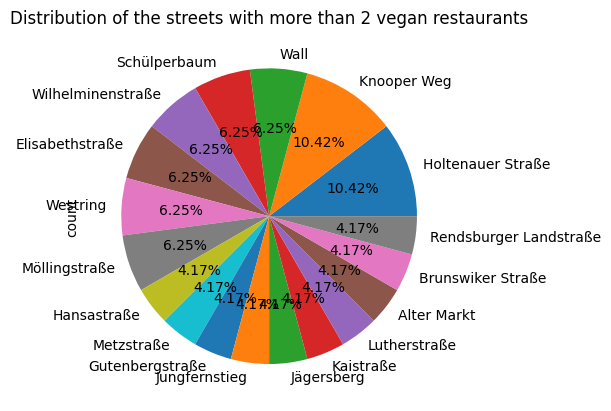

In [ ]:
# only return the values that are represented 2 or more times

# Only return the values that are represented 2 or more times
data_filtered = data["addr:street"].value_counts()[data["addr:street"].value_counts() >= 2]

# Plot the pie chart with labels
data_filtered.plot.pie(autopct="%1.2f%%")
plt.title("Distribution of the streets with more than 2 vegan restaurants")
plt.show()

<Axes: ylabel='count'>

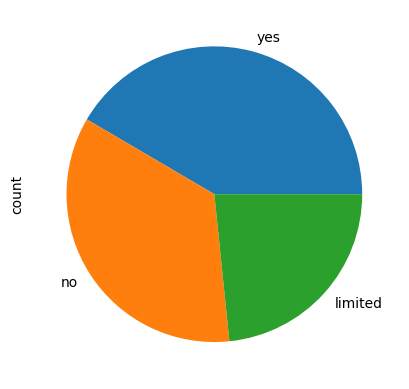

In [ ]:
data["wheelchair"].value_counts().plot.pie()

# Clustering

By the rule of thumb a silhouette score is between 0.5 ≥ sC > 0.25 so we have a weak structure wich is close to a usable structure

In [ ]:
# itterate trough the clusters and print the number of data instances

for cluster in range(n_clusters):
    cluster_data = data[data['cluster'] == cluster]
    print(f'Cluster {cluster + 1}: {cluster_data.shape[0]} data instances')


# Source of Code: 06_2_clans_iris.ipynb

Cluster 1: 26 data instances
Cluster 2: 38 data instances
Cluster 3: 5 data instances
Cluster 4: 2 data instances
Cluster 5: 24 data instances
Cluster 6: 1 data instances


# Removing Outlayers:

In [ ]:
# drop rows with the clusters 3 4 and 6

data.drop(data[data["cluster"] == 2].index, inplace=True)
data.drop(data[data["cluster"] == 3].index, inplace=True)
data.drop(data[data["cluster"] == 5].index, inplace=True)

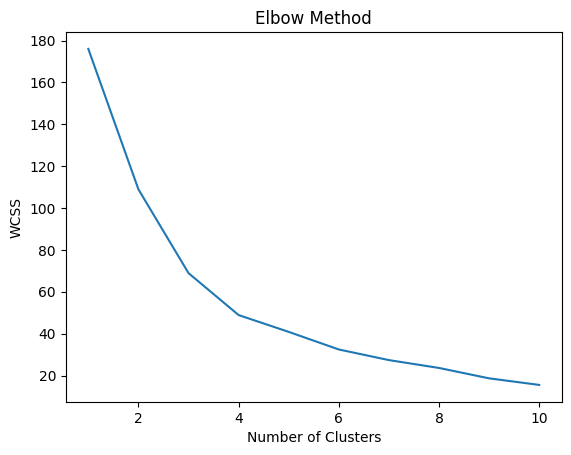

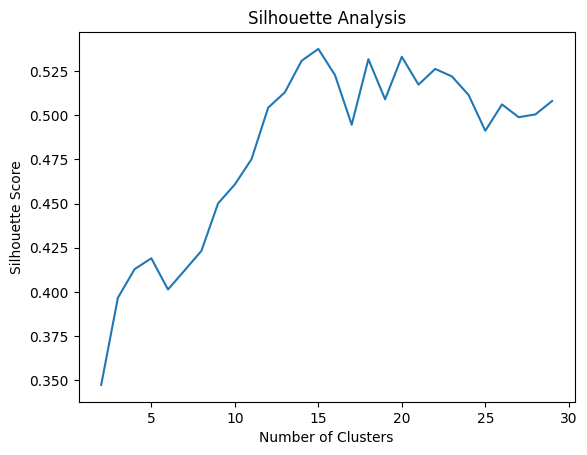

The silhouette score for the best cluster is: 0.5374083718130481


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Select the columns of interest
selected_columns = data[["lat", "lon"]]

# Standardize the data
scaler = StandardScaler()
selected_columns_scaled = scaler.fit_transform(selected_columns)

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
selected_columns_pca = pca.fit_transform(selected_columns_scaled)

# Perform elbow method to find the optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(selected_columns_pca)
    wcss.append(kmeans.inertia_)

# Plot the elbow method
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# Perform silhouette analysis
silhouette_scores = []
for i in range(2, 30):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(selected_columns_pca)
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(selected_columns_pca, labels))

# Plot silhouette scores
plt.plot(range(2, 30), silhouette_scores)
plt.title('Silhouette Analysis')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# returning the silhouette score for the best cluster
print("The silhouette score for the best cluster is: " + str(max(silhouette_scores)))

/home/mbrucker/sem1/sem1_math_and_stats/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


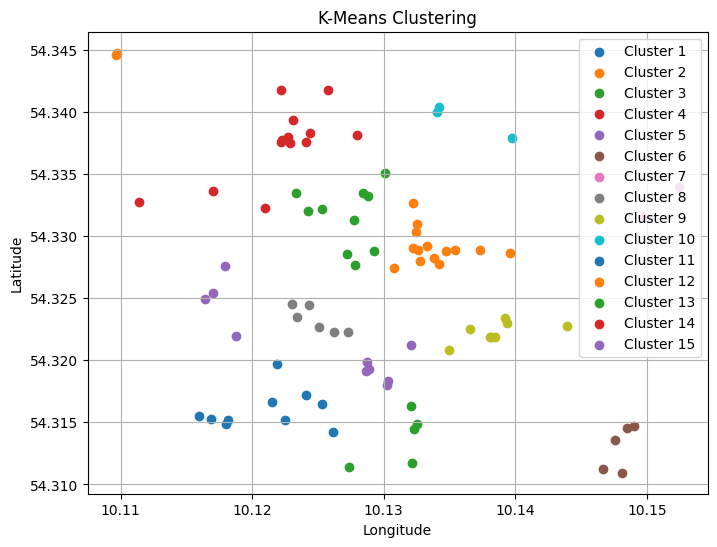

In [ ]:
# Define the number of clusters (you can use the result from the elbow method)
n_clusters = 15

# Perform K-Means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(selected_columns_scaled)

# Add cluster labels to the DataFrame
data['cluster'] = kmeans.labels_

# Create a scatter plot with clusters
plt.figure(figsize=(8, 6))
for cluster in range(n_clusters):
    cluster_data = data[data['cluster'] == cluster]
    plt.scatter(cluster_data['lon'], cluster_data['lat'], label=f'Cluster {cluster + 1}')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('K-Means Clustering')
plt.legend()
plt.grid(True)
plt.show()


# Analyzing the Clusters

In [ ]:
# return the unique sum of amenitys inside each cluster name the type of amiety

for cluster in range(n_clusters):
    cluster_data = data[data['cluster'] == cluster]
    print(f'Cluster {cluster + 1}: {cluster_data["amenity"].unique()}')

Cluster 1: ['cafe', 'fast_food', 'pub', 'restaurant', 'ice_cream']
Categories (5, object): ['cafe', 'fast_food', 'ice_cream', 'pub', 'restaurant']
Cluster 2: ['fast_food', 'cafe', 'restaurant', 'pub', 'ice_cream']
Categories (5, object): ['cafe', 'fast_food', 'ice_cream', 'pub', 'restaurant']
Cluster 3: ['fast_food', 'restaurant', 'ice_cream']
Categories (5, object): ['cafe', 'fast_food', 'ice_cream', 'pub', 'restaurant']
Cluster 4: ['fast_food']
Categories (5, object): ['cafe', 'fast_food', 'ice_cream', 'pub', 'restaurant']
Cluster 5: ['restaurant', 'cafe', 'fast_food', 'ice_cream']
Categories (5, object): ['cafe', 'fast_food', 'ice_cream', 'pub', 'restaurant']
Cluster 6: ['fast_food']
Categories (5, object): ['cafe', 'fast_food', 'ice_cream', 'pub', 'restaurant']


## Geografische beschreibung der Cluster

- Cluster 1 Bahnhof
- Cluster 2 Innenstadt
- Cluster 3 Hassee
- Cluster 4 Schönkirchen
- Cluster 5 Universität